In [ ]:
#Mount Google drive for persistent input/output storage
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Loading in our data and importing necessary packages
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Variables: Change for each disease and change file/path names as appropriate

#Disease label from labels.csv
diseasetarget = 'hemorrhage'
# specify path to labels.csv
labels_csv_path = '/content/drive/MyDrive/AI/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.0/labels.csv'
# Source directory with all images
source_directory = "/content/drive/MyDrive/AI/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.0/fundus_photos"
# Specify directory to move class images to.
# Subsequent code will create sub-directories for each class and move images to the appropriate class sub-directory
# DO NOT PUT ANYTHING ELSE HERE or the routine for creating training/validation dataset will fail
target_maindir = "/content/drive/MyDrive/AI/Hemorrhage"
# Path and filename for model. This cannot be under the target_maindir
model_save_path = '/content/drive/MyDrive/AI/Models/hemorrhage02122024.h5'

In [ ]:
# Read labels into a dataframe
data_frame = pd.read_csv(labels_csv_path)
# Data Profiling: Peek into the Labels
data_frame.head()

,image_id,patient_id,camera,patient_age,comorbidities,diabetes_time_y,insuline,patient_sex,exam_eye,diabetes,...,amd,vascular_occlusion,hypertensive_retinopathy,drusens,hemorrhage,retinal_detachment,myopic_fundus,increased_cup_disc,other,quality
0,img00001,1,Canon CR,48.0,diabetes1,12,yes,1,1,yes,...,0,0,0,0,0,0,0,1,0,Adequate
1,img00002,1,Canon CR,48.0,diabetes1,12,yes,1,2,yes,...,0,0,0,0,0,0,0,1,0,Adequate
2,img00003,2,Canon CR,18.0,diabetes1,7,yes,2,1,yes,...,0,0,0,0,0,0,0,0,0,Adequate
3,img00004,2,Canon CR,18.0,diabetes1,7,yes,2,2,yes,...,0,0,0,0,0,0,0,0,0,Adequate
4,img00005,3,Canon CR,22.0,diabetes1,11,yes,1,1,yes,...,0,0,0,0,0,0,0,0,0,Adequate


In [ ]:
# For simplicity, create a new data frame with just the image ID and disease target label
new_data = data_frame[['image_id',diseasetarget]]
# Data Profiling: Peek into the new data frame
new_data.head()

,image_id,hemorrhage
0,img00001,0
1,img00002,0
2,img00003,0
3,img00004,0
4,img00005,0


In [ ]:
# Data Profiling: Distribution of Class 0 and 1 images. We need to "balance" images between class 0 and 1.
# Minority class (typically Class 1 with disease) should be around 1000 images.
#     If < 1000, then "synthesize" additional images to reach 1000. Make additional identical copies and rely on "augmentation" to randomize each copy
# Majority class (typically class 0 for without disease) should be downsampled to Minority Class
new_data[diseasetarget].value_counts()

0    16170
1       96
Name: hemorrhage, dtype: int64

In [ ]:
# Create a Class 0 specific data frame
# downsampling class 0 to 1000 since data profiling indicated class 1 < 1000. If > 1000, then downsample to the class 1 count
class0_df = new_data[new_data[diseasetarget] == 0].sample(n=1000)
# Create a Class 1 specific data frame
# < 1000 images based on above data profiling. Create additional identical copies below to come close to 1000
class1_df = new_data[new_data[diseasetarget] == 1]
# Combine the 2 dataframes into one new data frame
new_data = pd.concat([class0_df, class1_df])
new_data.shape

(1096, 2)

In [ ]:
#####################################################################################################
############################################# IMAGE COPY ############################################
#####################################################################################################
# create sub-directories for each class and move images to the appropriate class sub-directory
# If Minority class images < 1000, then "synthesize" additional images to reach 1000.
# Make additional identical copies and rely on "augmentation" in a later code block to randomize each copy
import shutil
import os
from tqdm import tqdm

# Create the main directory under which class specific sub-directories will be created later
if not os.path.exists(target_maindir):
    os.makedirs(target_maindir)

# Determine number of unique classes (to make sub-directory). Typically 2 (class 0: No disease, class 1: with disease)
num_classes = new_data[diseasetarget].nunique()
# Initialize an Array of class sub-directories that will store the full path to the /0 and /1 sub-directories
class_directories = {}

# Create class sub-directories (e.g. ../0 and ../1) and also append class directories array
# For each class
for i in range(num_classes):
  # Form the sub-directory path: "Target Main Directory + /Class label ((e.g. ../0 and ../1))""
  class_directory = os.path.join(target_maindir, str(i)) #sub-directory
  # Make this sub-directory
  os.makedirs(class_directory, exist_ok=True)
  # append the /0 or /1 class sub-directory path to the class directories array
  # Index 0 will store the path for .../0 and index 1 will store the path for .../1
  class_directories[i] = class_directory

# Move each image to its appropriate sub-directory along with additional identical copies (if required)
# For each row in the data frame (represents the downsampled class 0 images + class 1 images)
# The iterator for the FOR loop is simply the number of rows (length) in the new_data dataframe from above
# use a progress bar by including the OPTIONAL tqdm feature
for i in tqdm(range(len(new_data))):
  # Create a filename by appending .jpg to the image_id. "i" is the for loop index/iterator and iloc[i] accesses the appropriate data frame index. Row 0, then 1, 2,...
  file_name = new_data['image_id'].iloc[i] + ".jpg"
  # Create the exact "source" image file path by combining the location where the fundus images can be found and the file name from above
  source = os.path.join(source_directory, file_name)

  # Now "copy" the source image file to the sub-directories.
  # Make additional identical copies and rely on "augmentation" in a later code block to randomize each copy

  # check if source image file exists
  if os.path.exists(source):
    # Look at labels.csv for the class label (0 or 1) for this particular dataframe row (image)
    class_label = new_data[diseasetarget].iloc[i]
    # Get the path for the approriate sub-directory
    target_directory = class_directories[class_label]

    # Copy from fundus images source to target 0 sub-directory.
    if class_label == 0:
      shutil.copy(source, target_directory)
    # Copy from fundus images source to target 1 sub-directory.
    # Also create additional identical image copies in this sub-directory if data synthesis is required.
    elif class_label == 1:
      shutil.copy(source, target_directory)
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_1.jpg"))
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_2.jpg"))
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_3.jpg"))
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_4.jpg"))
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_5.jpg"))
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_6.jpg"))
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_7.jpg"))
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_8.jpg"))
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_9.jpg"))

100%|██████████| 1096/1096 [08:26<00:00,  2.16it/s]


In [ ]:
# Data profiling to see if the sub-directories (classes) contain the expected images after downsampling (class 0) and synthesis (class 1)
import os
for dir in os.listdir(target_maindir):
  print(dir, len(os.listdir(os.path.join(target_maindir, dir))))

0 999
1 960


In [ ]:
#####################################################################################################
############################################# Create TRAINING and VALIDATION Datasets################
#####################################################################################################
from tqdm import tqdm
import tensorflow as tf
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Define the target size of images and batch size
img_height = 224
img_width = 224
batch_size = 32

# For just 2 classes (class 0 and class 1), use binary which will yield a single number as output. This is a probability in the 0 to 1 range.
# e.g. 0.69 is 69% probability of 1 (class 1. i.e. with disease)
if num_classes <= 2:
  label_mode = 'binary'
# For more than 2 classes (DR_ICDR for diabetic retinopathy classes - class 0, 1, 2, 3, 4), use categorical which will yield probabilities for each class
else:
  label_mode = 'categorical'

# Train/test split: Training dataset from the target directory containing the sub-directories (class 0, 1). Leave 20% (0.2) for validation dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  target_maindir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  label_mode=label_mode,
  batch_size=batch_size)

# Train/test split: Validation dataset from the target directory containing the sub-directories (class 0, 1).
# True performance of an AI model is based on how it does on non-training (unseen) data. So save some for validation later.
val_ds = tf.keras.utils.image_dataset_from_directory(
  target_maindir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode=label_mode,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Define the augmentation layer to introduce random variations into each image
data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(0.1),
  layers.RandomZoom(0.1),
  layers.RandomHeight(0.1),
  layers.RandomWidth(0.1),
  layers.RandomBrightness(0.1),
  layers.RandomTranslation(0.1, 0.1),
])

# Run augmentatation function on the training dataset
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Performance boosting via Auto-tuning
# AUTO-TUNE: number of elements to prefetch to the TensorFlow data runtime
AUTOTUNE = tf.data.experimental.AUTOTUNE if hasattr(tf.data, 'experimental') else tf.data.AUTOTUNE
# Use AUTOTUNE number of elements to prefetch
augmented_train_ds = augmented_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create a normalization layer and apply it to the training and validation datasets
# The color (RGB) values are in a range of 0-255 (256 shades of Red, Green, Blue) for each pixel
# AI does not work well with such large numbers. Bring the range down to 0-1
# This will result in each image be a multi-dimensional array with each value in the range 0-1.
normalization_layer = layers.Rescaling(1./255)
# Use the augmented training data set to create the final normalized training dataset.
normalized_train_ds = augmented_train_ds.map(lambda x, y: (normalization_layer(x), y))
# No augmentation required for validation dataset (that is our challenge!)
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


Found 1959 files belonging to 2 classes.
Using 1568 files for training.
Found 1959 files belonging to 2 classes.
Using 391 files for validation.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)              

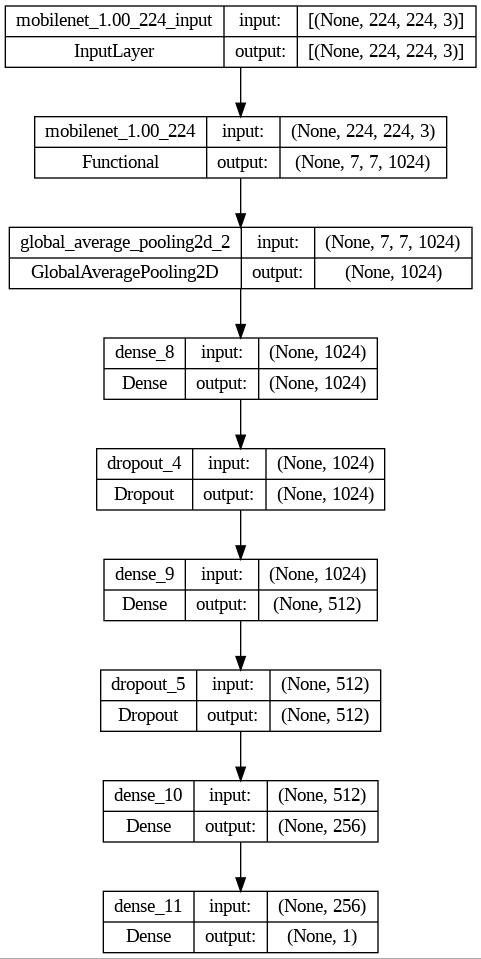

In [ ]:
#####################################################################################################
######################## Define, Compile and Plot a CNN Model with MobileNet as a base ##############
#####################################################################################################
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
import datetime

# HYPERPARAMETERS
INPUT_SHAPE = (224, 224, 3)
LR = 4e-5
DROPOUT = .25
TRANSFER_DROPOUT = .25
ALPHA = 1
BATCH_SIZE = 32
NUM_FREEZE = 80 #Mobilenet base layers to freeze training (i.e. no re-training)
NUM_EPOCHS = 30
MONITOR = 'val_recall' # Monitor validation loss
PATIENCE = 5 # Number of epochs with no improvement after which training will be stopped

# Early Stopping callback
early_stopping = EarlyStopping(
    monitor=MONITOR,
    patience=PATIENCE,
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)

# Model Checkpoint callback
model_checkpoint = ModelCheckpoint(
    model_save_path,   # Path where to save the model
    monitor=MONITOR,  # Monitor validation loss
    save_best_only=True  # Only save the best model
)

# Model Definition and layers
def MobileNet(num_freeze, num_classes, **kwargs):
    # Use MobileNet with imagenet as base (1000s of pre-trained images). Good starting point.
    base_model = tf.keras.applications.MobileNet(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False, **kwargs)
    # We dont want to re-train the base model layers
    for i in range(num_freeze):
      base_model.layers[i].trainable = False

    # Model definition = Base + Dense layers (transfer learning)
    model= tf.keras.Sequential([
        # Start with a pre-trained MobileNet base
        base_model,
        # Add our own dense layers to the MobileNet pre-trained base
        # These dense layers will extract (i.e. "learn") disease specific features
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(DROPOUT),
        Dense(512, activation='relu'),
        Dropout(DROPOUT),
        Dense(256, activation='relu'),
    ])
    # Add the last OUTPUT layer
    # For just 2 classes (class 0 and class 1), use binary (SIGMOID) which will yield a single number as output. This is a probability in the 0 to 1 range.
    # e.g. 0.69 is 69% probability of 1 (class 1. i.e. with disease)
    if num_classes <= 2:
        model.add(Dense(1, activation='sigmoid'))
    # For more than 2 classes (DR_ICDR for diabetic retinopathy classes - class 0, 1, 2, 3, 4)
    # ..use SOFTMAX which will yield probabilities for each class
    else:
        model.add(Dense(num_classes, activation='softmax'))
    return model

# Create a Model using the above function definition
model = MobileNet(num_freeze=NUM_FREEZE, num_classes=num_classes, dropout=TRANSFER_DROPOUT, alpha=ALPHA)
optimizer = Adam(learning_rate=LR)
if num_classes <= 2:
    loss = 'binary_crossentropy'
else:
    loss = 'categorical_crossentropy'

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
    ]
)

# Plot the Model and save the model as a JPG image for future reference
from keras.utils import plot_model
model.summary()
model_img_save_path = model_save_path + '.jpg'
plot_model(model, to_file=model_img_save_path, show_shapes=True, show_layer_names=True)

In [ ]:
#####################################################################################################
######################## Train the Model ##############
#####################################################################################################
# Fit the model with callbacks
history = model.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs=NUM_EPOCHS,
    verbose=True,
    class_weight=None,
    callbacks=[early_stopping, model_checkpoint]
    #callbacks=[early_stopping, model_checkpoint,tensorboard_callback]  # Add callbacks here
)

Epoch 1/30
49/49 [==============================] - ETA: 0s - loss: 0.6748 - precision_2: 0.5995 - recall_2: 0.5863 - auc_2: 0.6280

49/49 [==============================] - 189s 4s/step - loss: 0.6748 - precision_2: 0.5995 - recall_2: 0.5863 - auc_2: 0.6280 - val_loss: 0.6623 - val_precision_2: 0.9474 - val_recall_2: 0.1905 - val_auc_2: 0.7567
Epoch 2/30
49/49 [==============================] - ETA: 0s - loss: 0.5718 - precision_2: 0.7267 - recall_2: 0.7069 - auc_2: 0.7844

49/49 [==============================] - 100s 2s/step - loss: 0.5718 - precision_2: 0.7267 - recall_2: 0.7069 - auc_2: 0.7844 - val_loss: 0.6226 - val_precision_2: 0.9138 - val_recall_2: 0.2804 - val_auc_2: 0.8061
Epoch 3/30
49/49 [==============================] - ETA: 0s - loss: 0.5182 - precision_2: 0.7573 - recall_2: 0.7445 - auc_2: 0.8298

49/49 [==============================] - 97s 2s/step - loss: 0.5182 - precision_2: 0.7573 - recall_2: 0.7445 - auc_2: 0.8298 - val_loss: 0.5575 - val_precision_2: 0.8396 - val_recall_2: 0.4709 - val_auc_2: 0.8262
Epoch 4/30
49/49 [==============================] - ETA: 0s - loss: 0.4700 - precision_2: 0.7845 - recall_2: 0.7743 - auc_2: 0.8647

49/49 [==============================] - 94s 2s/step - loss: 0.4700 - precision_2: 0.7845 - recall_2: 0.7743 - auc_2: 0.8647 - val_loss: 0.5162 - val_precision_2: 0.7943 - val_recall_2: 0.5926 - val_auc_2: 0.8399
Epoch 5/30
49/49 [==============================] - ETA: 0s - loss: 0.4036 - precision_2: 0.8283 - recall_2: 0.8132 - auc_2: 0.9071

49/49 [==============================] - 98s 2s/step - loss: 0.4036 - precision_2: 0.8283 - recall_2: 0.8132 - auc_2: 0.9071 - val_loss: 0.4850 - val_precision_2: 0.7611 - val_recall_2: 0.7249 - val_auc_2: 0.8512
Epoch 6/30
49/49 [==============================] - ETA: 0s - loss: 0.3550 - precision_2: 0.8660 - recall_2: 0.8379 - auc_2: 0.9319

49/49 [==============================] - 95s 2s/step - loss: 0.3550 - precision_2: 0.8660 - recall_2: 0.8379 - auc_2: 0.9319 - val_loss: 0.4982 - val_precision_2: 0.7222 - val_recall_2: 0.8254 - val_auc_2: 0.8538
Epoch 7/30
49/49 [==============================] - ETA: 0s - loss: 0.2967 - precision_2: 0.8813 - recall_2: 0.8859 - auc_2: 0.9554

49/49 [==============================] - 99s 2s/step - loss: 0.2967 - precision_2: 0.8813 - recall_2: 0.8859 - auc_2: 0.9554 - val_loss: 0.6439 - val_precision_2: 0.6293 - val_recall_2: 0.9788 - val_auc_2: 0.8558
Epoch 8/30
49/49 [==============================] - ETA: 0s - loss: 0.2375 - precision_2: 0.9142 - recall_2: 0.9118 - auc_2: 0.9766

49/49 [==============================] - 100s 2s/step - loss: 0.2375 - precision_2: 0.9142 - recall_2: 0.9118 - auc_2: 0.9766 - val_loss: 0.7174 - val_precision_2: 0.6208 - val_recall_2: 0.9788 - val_auc_2: 0.8607
Epoch 9/30
49/49 [==============================] - ETA: 0s - loss: 0.1887 - precision_2: 0.9321 - recall_2: 0.9442 - auc_2: 0.9866

49/49 [==============================] - 100s 2s/step - loss: 0.1887 - precision_2: 0.9321 - recall_2: 0.9442 - auc_2: 0.9866 - val_loss: 0.6968 - val_precision_2: 0.6307 - val_recall_2: 0.9577 - val_auc_2: 0.8623
Epoch 10/30
49/49 [==============================] - ETA: 0s - loss: 0.1445 - precision_2: 0.9596 - recall_2: 0.9546 - auc_2: 0.9933

49/49 [==============================] - 99s 2s/step - loss: 0.1445 - precision_2: 0.9596 - recall_2: 0.9546 - auc_2: 0.9933 - val_loss: 0.7802 - val_precision_2: 0.6293 - val_recall_2: 0.9788 - val_auc_2: 0.8596
Epoch 11/30
49/49 [==============================] - ETA: 0s - loss: 0.0997 - precision_2: 0.9743 - recall_2: 0.9831 - auc_2: 0.9981

49/49 [==============================] - 95s 2s/step - loss: 0.0997 - precision_2: 0.9743 - recall_2: 0.9831 - auc_2: 0.9981 - val_loss: 0.6515 - val_precision_2: 0.6822 - val_recall_2: 0.9312 - val_auc_2: 0.8595
Epoch 12/30
49/49 [==============================] - ETA: 0s - loss: 0.0717 - precision_2: 0.9922 - recall_2: 0.9857 - auc_2: 0.9993

49/49 [==============================] - 108s 2s/step - loss: 0.0717 - precision_2: 0.9922 - recall_2: 0.9857 - auc_2: 0.9993 - val_loss: 0.5520 - val_precision_2: 0.7204 - val_recall_2: 0.8042 - val_auc_2: 0.8629
Epoch 13/30
49/49 [==============================] - ETA: 0s - loss: 0.0603 - precision_2: 0.9922 - recall_2: 0.9857 - auc_2: 0.9996

49/49 [==============================] - 99s 2s/step - loss: 0.0603 - precision_2: 0.9922 - recall_2: 0.9857 - auc_2: 0.9996 - val_loss: 0.5741 - val_precision_2: 0.7400 - val_recall_2: 0.7831 - val_auc_2: 0.8614
Epoch 14/30
49/49 [==============================] - ETA: 0s - loss: 0.0464 - precision_2: 0.9884 - recall_2: 0.9935 - auc_2: 0.9997

49/49 [==============================] - 99s 2s/step - loss: 0.0464 - precision_2: 0.9884 - recall_2: 0.9935 - auc_2: 0.9997 - val_loss: 0.5967 - val_precision_2: 0.7308 - val_recall_2: 0.8042 - val_auc_2: 0.8581
Epoch 15/30
49/49 [==============================] - ETA: 0s - loss: 0.0424 - precision_2: 0.9948 - recall_2: 0.9870 - auc_2: 0.9997

49/49 [==============================] - 101s 2s/step - loss: 0.0424 - precision_2: 0.9948 - recall_2: 0.9870 - auc_2: 0.9997 - val_loss: 0.6662 - val_precision_2: 0.7051 - val_recall_2: 0.8095 - val_auc_2: 0.8561
Epoch 16/30
49/49 [==============================] - ETA: 0s - loss: 0.0280 - precision_2: 0.9974 - recall_2: 0.9935 - auc_2: 0.9999

49/49 [==============================] - 97s 2s/step - loss: 0.0280 - precision_2: 0.9974 - recall_2: 0.9935 - auc_2: 0.9999 - val_loss: 0.8404 - val_precision_2: 0.6721 - val_recall_2: 0.8677 - val_auc_2: 0.8488
Epoch 17/30
49/49 [==============================] - ETA: 0s - loss: 0.0140 - precision_2: 0.9974 - recall_2: 1.0000 - auc_2: 1.0000

49/49 [==============================] - 103s 2s/step - loss: 0.0140 - precision_2: 0.9974 - recall_2: 1.0000 - auc_2: 1.0000 - val_loss: 0.7146 - val_precision_2: 0.7009 - val_recall_2: 0.8307 - val_auc_2: 0.8642
Epoch 18/30
49/49 [==============================] - ETA: 0s - loss: 0.0110 - precision_2: 0.9987 - recall_2: 1.0000 - auc_2: 1.0000

49/49 [==============================] - 96s 2s/step - loss: 0.0110 - precision_2: 0.9987 - recall_2: 1.0000 - auc_2: 1.0000 - val_loss: 0.7331 - val_precision_2: 0.7035 - val_recall_2: 0.8413 - val_auc_2: 0.8578
Epoch 19/30
49/49 [==============================] - ETA: 0s - loss: 0.0090 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000

49/49 [==============================] - 100s 2s/step - loss: 0.0090 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000 - val_loss: 0.7346 - val_precision_2: 0.7067 - val_recall_2: 0.8413 - val_auc_2: 0.8587
Epoch 20/30
49/49 [==============================] - ETA: 0s - loss: 0.0069 - precision_2: 0.9987 - recall_2: 1.0000 - auc_2: 1.0000

49/49 [==============================] - 98s 2s/step - loss: 0.0069 - precision_2: 0.9987 - recall_2: 1.0000 - auc_2: 1.0000 - val_loss: 0.6960 - val_precision_2: 0.7617 - val_recall_2: 0.7778 - val_auc_2: 0.8526
Epoch 21/30
49/49 [==============================] - ETA: 0s - loss: 0.0066 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000

49/49 [==============================] - 123s 3s/step - loss: 0.0066 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000 - val_loss: 0.7015 - val_precision_2: 0.7513 - val_recall_2: 0.7831 - val_auc_2: 0.8564
Epoch 22/30
49/49 [==============================] - ETA: 0s - loss: 0.0046 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000

49/49 [==============================] - 96s 2s/step - loss: 0.0046 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000 - val_loss: 0.7181 - val_precision_2: 0.7475 - val_recall_2: 0.7831 - val_auc_2: 0.8514
Epoch 23/30
49/49 [==============================] - ETA: 0s - loss: 0.0057 - precision_2: 1.0000 - recall_2: 0.9974 - auc_2: 1.0000

49/49 [==============================] - 102s 2s/step - loss: 0.0057 - precision_2: 1.0000 - recall_2: 0.9974 - auc_2: 1.0000 - val_loss: 0.8871 - val_precision_2: 0.6833 - val_recall_2: 0.8677 - val_auc_2: 0.8455
Epoch 24/30
49/49 [==============================] - ETA: 0s - loss: 0.0045 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000

49/49 [==============================] - 100s 2s/step - loss: 0.0045 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000 - val_loss: 0.7601 - val_precision_2: 0.7462 - val_recall_2: 0.7778 - val_auc_2: 0.8523
Epoch 25/30
49/49 [==============================] - ETA: 0s - loss: 0.0037 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000

49/49 [==============================] - 99s 2s/step - loss: 0.0037 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000 - val_loss: 0.8225 - val_precision_2: 0.6978 - val_recall_2: 0.8307 - val_auc_2: 0.8511
Epoch 26/30
49/49 [==============================] - ETA: 0s - loss: 0.0040 - precision_2: 0.9987 - recall_2: 1.0000 - auc_2: 1.0000

49/49 [==============================] - 101s 2s/step - loss: 0.0040 - precision_2: 0.9987 - recall_2: 1.0000 - auc_2: 1.0000 - val_loss: 0.8508 - val_precision_2: 0.7027 - val_recall_2: 0.8254 - val_auc_2: 0.8458
Epoch 27/30
49/49 [==============================] - ETA: 0s - loss: 0.0031 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000

49/49 [==============================] - 99s 2s/step - loss: 0.0031 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000 - val_loss: 0.8933 - val_precision_2: 0.6996 - val_recall_2: 0.8624 - val_auc_2: 0.8447
Epoch 28/30
49/49 [==============================] - ETA: 0s - loss: 0.0031 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000

49/49 [==============================] - 100s 2s/step - loss: 0.0031 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000 - val_loss: 1.0101 - val_precision_2: 0.6870 - val_recall_2: 0.8942 - val_auc_2: 0.8410
Epoch 29/30
49/49 [==============================] - ETA: 0s - loss: 0.0024 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000

49/49 [==============================] - 101s 2s/step - loss: 0.0024 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000 - val_loss: 0.9533 - val_precision_2: 0.6894 - val_recall_2: 0.8571 - val_auc_2: 0.8451
Epoch 30/30
49/49 [==============================] - ETA: 0s - loss: 0.0022 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000

49/49 [==============================] - 98s 2s/step - loss: 0.0022 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000 - val_loss: 0.9483 - val_precision_2: 0.6926 - val_recall_2: 0.8466 - val_auc_2: 0.8465


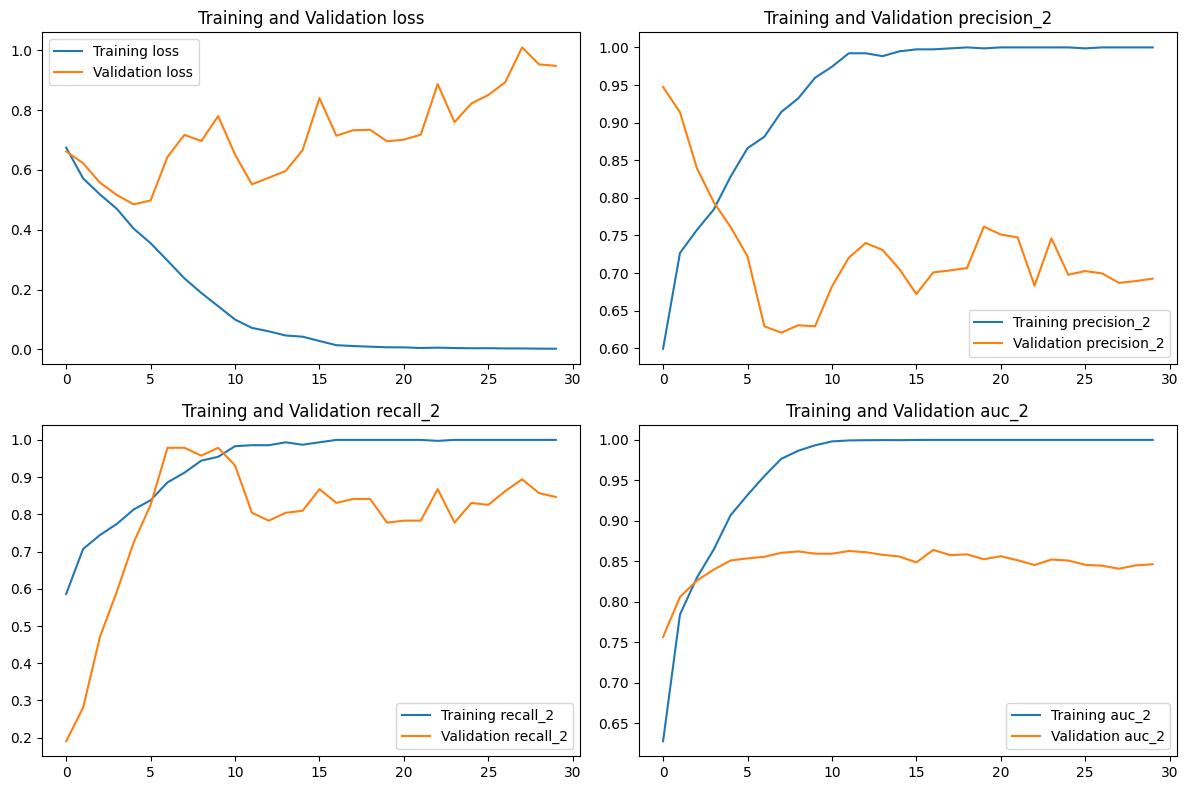

In [ ]:
#####################################################################################################
######################## Plot the Training Results metrics (Precision, Recall, etc.) ##############
#####################################################################################################
import matplotlib.pyplot as plt

metric_keys = list(history.history.keys())
num_metrics = len(metric_keys) // 2  # Assuming there's a validation metric for each training metric
epochs_range = range(len(history.history[metric_keys[0]]))  # Number of epochs

# Calculate the number of rows needed (each row contains plots for one metric and its validation counterpart)
num_rows = (num_metrics + 1) // 2 if num_metrics % 2 != 0 else num_metrics // 2

plt.figure(figsize=(12, 4 * num_rows))  # Adjust the figure size

for i in range(num_metrics):
    metric = metric_keys[i]
    val_metric = metric_keys[i + num_metrics]  # Validation metric corresponding to the training metric

    plt.subplot(num_rows, 2, i + 1)
    plt.plot(epochs_range, history.history[metric], label=f'Training {metric}')
    plt.plot(epochs_range, history.history[val_metric], label=f'Validation {metric}')
    plt.legend(loc='best')
    plt.title(f'Training and Validation {metric}')

plt.tight_layout()
plt.show()


In [ ]:
#####################################################################################################
######################## Plot the Confusion Matrix (FP, FN, TP, TN) and Classification Report #######
# FP: False Positive (Precision is a metric that tells how little false positives you have)
# FN: False Negative (Recall is a metric that tells how little false negatives you have)
# TP: True Positive
# TN: True Negative
#####################################################################################################
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Lower thresholds will improve recall (few FN) and higher ones will improve precision (few FP)
threshold = 0.28 #ADJUST based on model and disease. > threshold will be considered as 1!
# Load the model
model = load_model(model_save_path)

# COnfusion Matrix
# Prepare true labels
y_true = np.concatenate([y for x, y in normalized_val_ds], axis=0)
if num_classes > 2:
  y_true = np.argmax(y_true, axis=1)
# Make predictions
predictions = model.predict(normalized_val_ds)
if num_classes > 2:
  predictions = np.argmax(predictions, axis=1)
predictions = (np.squeeze(predictions) > threshold).astype(int)
disp = ConfusionMatrixDisplay.from_predictions(y_true, predictions)
disp.figure_.suptitle("Confusion Matrix")
plt.show()
# Classification Report
print(classification_report(y_true, predictions))

OSError: No file or directory found at /content/drive/MyDrive/AI/Models/hemorrhage02122024.h5

In [ ]:
#####################################################################################################
######################## Test with individual images #######
#####################################################################################################
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
from tensorflow.keras import layers
import os

# Load the model
model = load_model(model_save_path)

# Lower thresholds will improve recall (few FN) and higher ones will improve precision (few FP)
threshold = 28 #In %: ADJUST based on model and disease. > threshold will be considered as 1!

# Pick an image sample
imgpath = os.path.join(source_directory, 'img05405.jpg')

# Display the original image in full resolution
image = load_img(imgpath)
plt.imshow(image)

# Downscale image to fit training resolution
image = load_img(imgpath, target_size=(224, 224))
input_image = img_to_array(image)
input_image = input_image.reshape(1, 224, 224, 3)  # Add batch dimension and match model input shape

# Check for disease
# Print probability of disease.
def check_for_disease (diseasename,image,savedmodel):
    model = load_model(savedmodel)
    prediction = model.predict(image)
    prediction_prob = prediction[0][0] * 100 # Note the [][] since model predicts in format [[probablity in 0 to 1]]
    #Cast to Int (no decimals)
    prediction_prob = int(prediction_prob)

    # Print result and probability of disease.
    if prediction_prob > threshold:
        print(f"Eye image shows the patient has {diseasename} with probablity {prediction_prob} %")
    else:
        print(f"Eye image shows the patient does NOT have {diseasename} with probablity of disease at {prediction_prob} %")
# Check for disease
check_for_disease(diseasetarget,input_image,model_save_path)